<a href="https://colab.research.google.com/github/Michwynn/Capstone-Team-Air-/blob/Machine-Learning/Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings # supress warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm

# machine learning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# deep learning
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/Capstone

pd.set_option('display.max_columns', None)

# random seed 
RANDOM_SEED = 44

Mounted at /content/drive
/content/drive/My Drive/Capstone


**import files**

In [2]:
train_df = pd.read_csv("assets/cleaned_assets/train_df.csv", index_col = 0)
val_df = pd.read_csv("assets/cleaned_assets/val_df.csv", index_col = 0)
test_df = pd.read_csv("assets/cleaned_assets/test_df.csv", index_col = 0)

**Split into x_train & y_train, X_val & y_val and X_test & y_test**

In [3]:
outcome_vars = ['price', 'log_price']

X_train = train_df[train_df.columns.difference(outcome_vars)]
y_train = list(train_df.log_price)

X_val = val_df[val_df.columns.difference(outcome_vars)]
y_val = list(val_df.log_price)

X_test = test_df[test_df.columns.difference(outcome_vars)]
y_test = list(test_df.log_price)

**Baseline model - Using Statsmodel for multiple regression**

In [4]:
# prevent dummy variable trap for linear regression
baseline_vars = ['City of London', 
                 'host_has_profile_pic_f', 
                 'host_identity_verified_f', 
                 'Entire home', 
                 'Entire home/apt (room type)']

# drop in all splitted dfs
train_df_reference = train_df.drop(baseline_vars, axis=1)
val_df_reference = val_df.drop(baseline_vars, axis=1)
test_df_reference = test_df.drop(baseline_vars, axis=1)

X_train_reference = train_df_reference[train_df_reference.columns.difference(outcome_vars)]
y_train_reference = list(train_df.log_price)

X_val_reference = val_df_reference[val_df_reference.columns.difference(outcome_vars)]
y_val_reference = list(val_df_reference.log_price)

X_test_reference = test_df_reference[test_df_reference.columns.difference(outcome_vars)]
y_test_reference = list(test_df_reference.log_price)

# initialise the linear regression model
model = sm.OLS(y_train_reference, X_train_reference).fit()
print(model.summary())
print("The Durbin Watson test statistic is",  durbin_watson(model.resid), "Since this is within the range of 1.5 and 2.5, autocorrelation is not an issue this regression model.")

# prediction
prediction = model.predict(X_val_reference)
rmse_linearreg = mean_squared_error(y_val_reference, prediction)
print("RMSE:", rmse_linearreg)
r_square_linearreg = model.rsquared_adj
print("R^2:", r_square_linearreg)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.625
Model:                            OLS   Adj. R-squared:                  0.624
Method:                 Least Squares   F-statistic:                     660.4
Date:                Mon, 27 Mar 2023   Prob (F-statistic):               0.00
Time:                        00:59:38   Log-Likelihood:                -38704.
No. Observations:               55188   AIC:                         7.769e+04
Df Residuals:                   55048   BIC:                         7.894e+04
Df Model:                         139                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Bark

**LinearRegression - Plotting Predicted Log values vs Actual Log values**

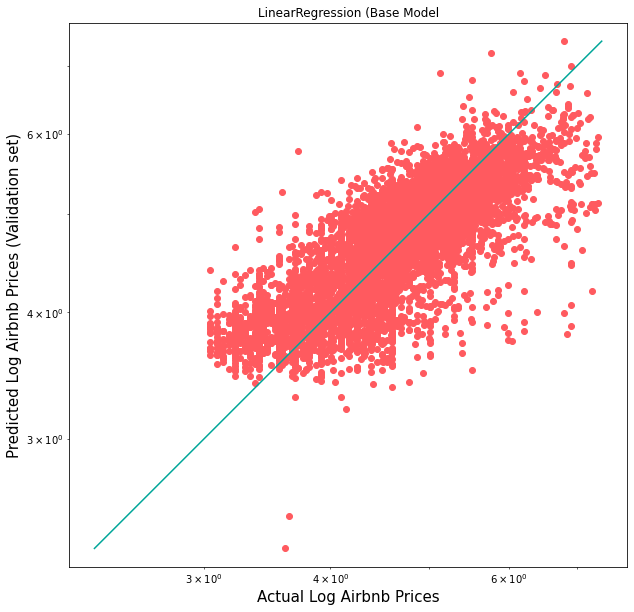

In [5]:
plt.figure(figsize=(10,10))
plt.scatter(y_val_reference, prediction, color = '#FF5A5F')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(prediction), max(y_val_reference))
p2 = min(min(prediction), min(y_val_reference))
plt.plot([p1, p2], [p1, p2], '#00A699')
plt.xlabel('Actual Log Airbnb Prices', fontsize=15)
plt.ylabel('Predicted Log Airbnb Prices (Validation set)', fontsize=15)
plt.axis('equal')
plt.title("LinearRegression (Base Model")
plt.show()

**Adding more Complexity - Other Modelling Techniques - Default parameters on Validation set**

  0%|          | 0/8 [00:00<?, ?it/s]

Ridge(random_state=44) RMSE: 0.4840919571304316
Ridge(random_state=44) Adjusted R^2: 0.614619349925799
-------------------------------


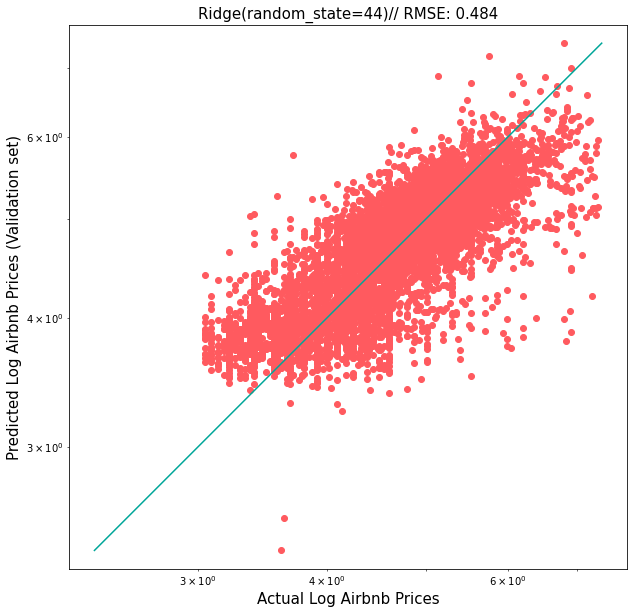

 12%|█▎        | 1/8 [00:01<00:08,  1.15s/it]

DecisionTreeRegressor(random_state=44) RMSE: 0.6352347004313856
DecisionTreeRegressor(random_state=44) Adjusted R^2: 0.336405774154905
-------------------------------


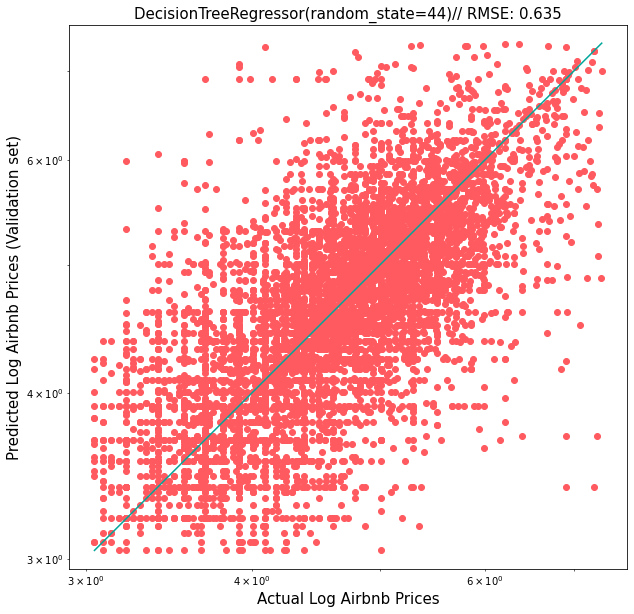

 25%|██▌       | 2/8 [00:05<00:19,  3.24s/it]

BaggingRegressor(random_state=44) RMSE: 0.4642736598032723
BaggingRegressor(random_state=44) Adjusted R^2: 0.6455277347316889
-------------------------------


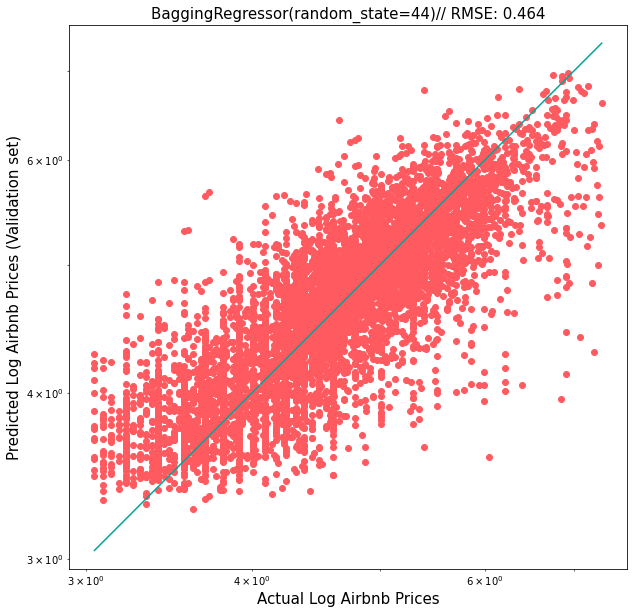

 38%|███▊      | 3/8 [00:17<00:35,  7.12s/it]

RandomForestRegressor(random_state=44) RMSE: 0.44290700645898395
RandomForestRegressor(random_state=44) Adjusted R^2: 0.6774037818881573
-------------------------------


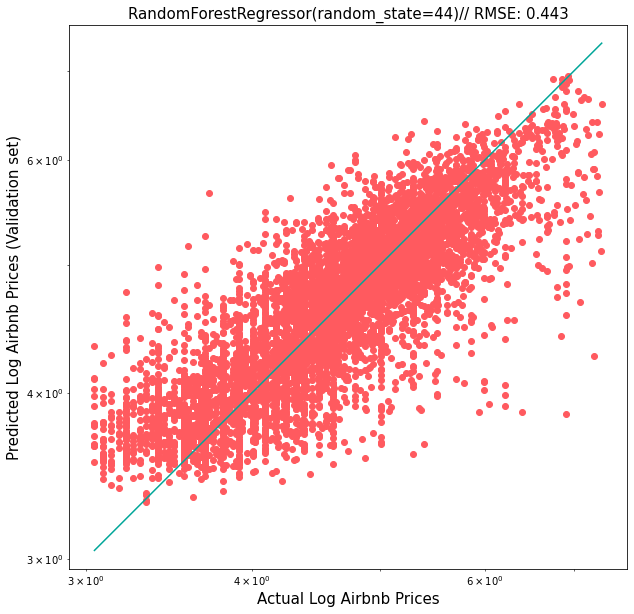

 50%|█████     | 4/8 [01:35<02:21, 35.25s/it]

ExtraTreesRegressor(random_state=44) RMSE: 0.4497949376140988
ExtraTreesRegressor(random_state=44) Adjusted R^2: 0.6672919591241734
-------------------------------


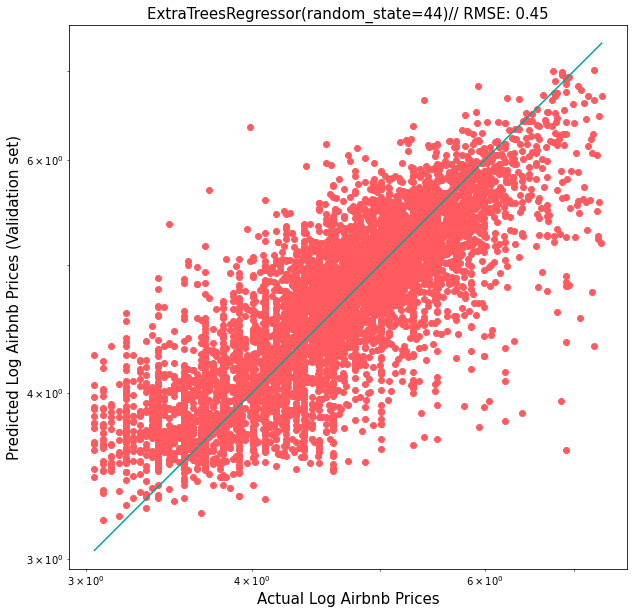

 62%|██████▎   | 5/8 [02:40<02:17, 45.89s/it]

AdaBoostRegressor(random_state=44) RMSE: 0.6584926843443983
AdaBoostRegressor(random_state=44) Adjusted R^2: 0.2869235733335963
-------------------------------


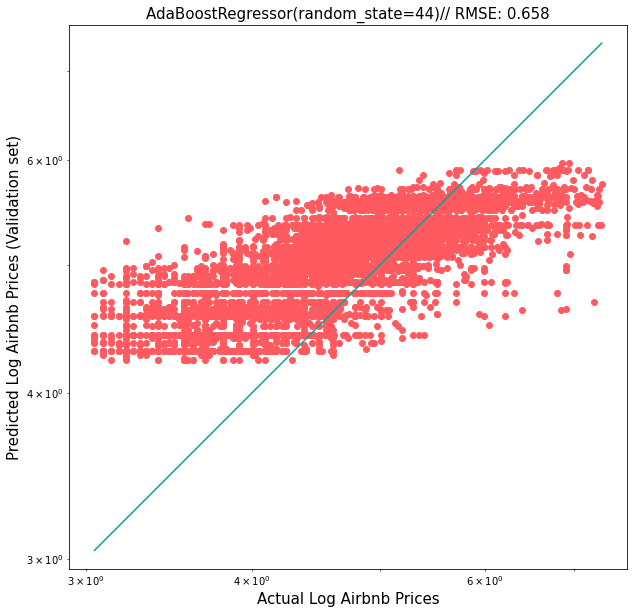

 75%|███████▌  | 6/8 [02:56<01:11, 35.79s/it]

LGBMRegressor(random_state=44) RMSE: 0.4445798913744681
LGBMRegressor(random_state=44) Adjusted R^2: 0.6749622512083235
-------------------------------


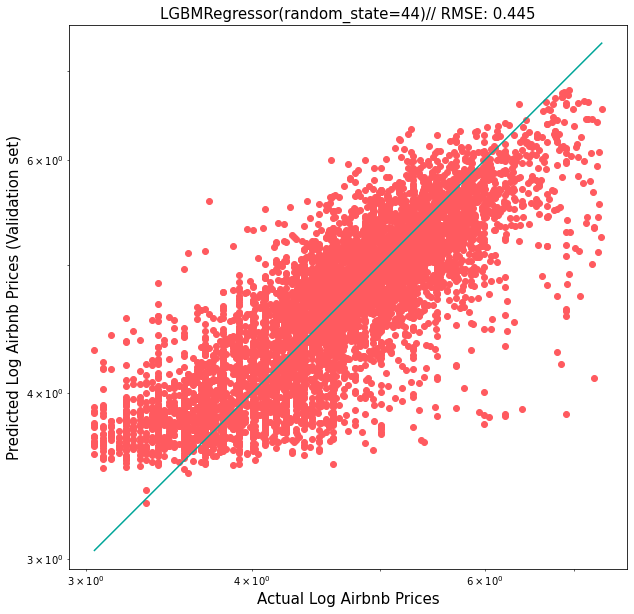

 88%|████████▊ | 7/8 [02:58<00:24, 24.45s/it]

KNeighborsRegressor() RMSE: 0.5043187333569538
KNeighborsRegressor() Adjusted R^2: 0.5817418886873622
-------------------------------


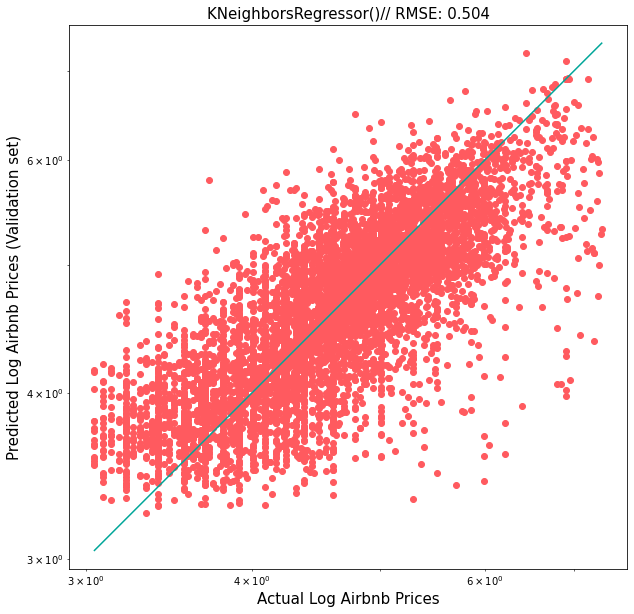

100%|██████████| 8/8 [03:04<00:00, 23.02s/it]


In [7]:
model_names = ['RidgeRegression',
               'DecisionTreeRegressor',
               'BaggingRegressor',
               'RandomForestRegressor',
               'ExtraTreesRegressor',
               'AdaBoostRegressor',
               'LGBMRegressor',
               'KNeighborsRegressor']


model_list =  [Ridge(random_state = RANDOM_SEED),
               DecisionTreeRegressor(random_state = RANDOM_SEED), 
               BaggingRegressor(random_state = RANDOM_SEED), 
               RandomForestRegressor(random_state = RANDOM_SEED),
               ExtraTreesRegressor(random_state = RANDOM_SEED),
               AdaBoostRegressor(random_state = RANDOM_SEED),
               lightgbm.LGBMRegressor(random_state = RANDOM_SEED),
               KNeighborsRegressor(n_neighbors=5)]
              
rmse_list = []
adjusted_r_square_list = []

for model in tqdm(model_list):
  
  model.fit(X_train, y_train)
  prediction = model.predict(X_val)

  # RMSE Caculation and append to list
  rmse_list.append(np.sqrt(mean_squared_error(y_val, prediction)))
  print(str(model), "RMSE:", np.sqrt(mean_squared_error(y_val, prediction)))

  # Adjusted R-square Caculation and append to list
  Adj_r2 = 1 - (1 - r2_score(y_val, prediction)) * ((len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
  adjusted_r_square_list.append(Adj_r2)
  print(str(model), "Adjusted R^2:", Adj_r2)
  print("-------------------------------")


  plt.figure(figsize=(10,10))
  plt.scatter(y_val, prediction, color = '#FF5A5F')
  plt.yscale('log')
  plt.xscale('log')

  p1 = max(max(prediction), max(y_val))
  p2 = min(min(prediction), min(y_val))
  plt.plot([p1, p2], [p1, p2], '#00A699')
  plt.xlabel('Actual Log Airbnb Prices', fontsize=15)
  plt.ylabel('Predicted Log Airbnb Prices (Validation set)', fontsize=15)
  plt.axis('equal')
  plt.title(str(model) + "// RMSE: " + str(np.round(np.sqrt(mean_squared_error(y_val, prediction)),3)), fontsize=15)
  plt.show()

In [8]:
# add linear regression result to both lists
model_names.insert(0, "LinearRegression (Base Model)")
rmse_list.insert(0, rmse_linearreg)
adjusted_r_square_list.insert(0, r_square_linearreg)

In [9]:
# plotting results of classifiers on default hyperparameters
df_plot = pd.DataFrame()
df_plot['Model Names'] = model_names
df_plot['RMSE'] = rmse_list
df_plot['Adj R-square'] = adjusted_r_square_list
df_plot = df_plot.set_index('Model Names')
df_plot.reset_index()

,Model Names,RMSE,Adj R-square
0,LinearRegression (Base Model),0.234618,0.624174
1,RidgeRegression,0.484092,0.614619
2,DecisionTreeRegressor,0.635235,0.336406
3,BaggingRegressor,0.464274,0.645528
4,RandomForestRegressor,0.442907,0.677404
5,ExtraTreesRegressor,0.449795,0.667292
6,AdaBoostRegressor,0.658493,0.286924
7,LGBMRegressor,0.444580,0.674962
8,KNeighborsRegressor,0.504319,0.581742


Text(0.5, 1.0, 'Scores on validation set - default hyperparameters')

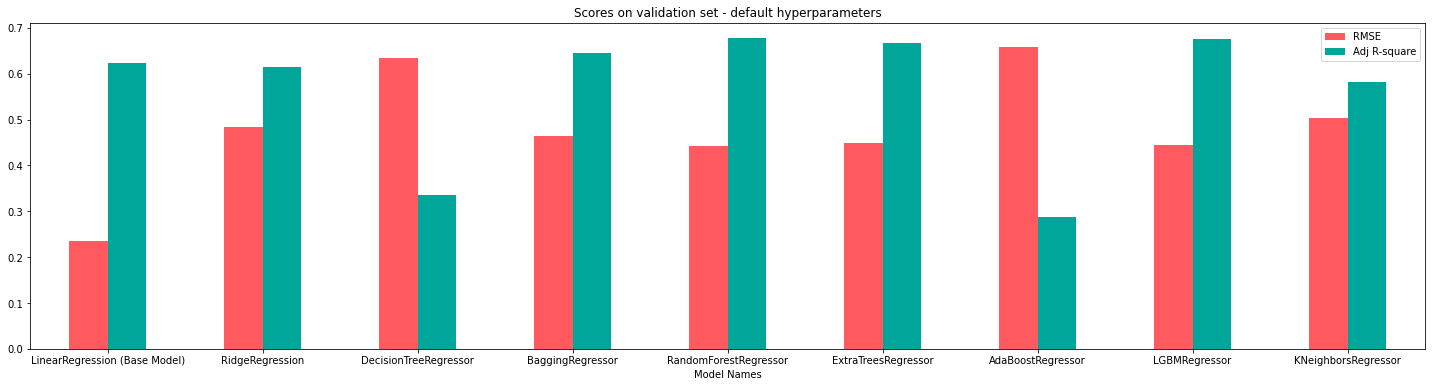

In [10]:
# plot the results
df_plot[['RMSE', 'Adj R-square']].plot(kind='bar', figsize=(25,6), color=['#FF5A5F', '#00A699'])
plt.xticks(rotation = 0)
plt.title("Scores on validation set - default hyperparameters")

**Hyperparameter Tuning on train set**

In [11]:
class EstimatorSelectionHelper:

    def __init__(self, models, params):
        if not set(models.keys()).issubset(set(params.keys())):
            missing_params = list(set(models.keys()) - set(params.keys()))
            raise ValueError("Some estimators are missing parameters: %s" % missing_params)
        self.models = models
        self.params = params
        self.keys = models.keys()
        self.grid_searches = {}

    def fit(self, X, y, cv=3, n_jobs=3, verbose=1, scoring=None, refit=False):
        for key in self.keys:
            print("Running GridSearchCV for %s." % key)
            model = self.models[key]
            params = self.params[key]
            gs = GridSearchCV(model, params, cv=cv, n_jobs=n_jobs,
                              verbose=verbose, scoring=scoring, refit=refit,
                              return_train_score=True)
            gs.fit(X,y)
            self.grid_searches[key] = gs    

    def score_summary(self, sort_by='mean_score'):
        def row(key, scores, params):
            d = {
                 'estimator': key,
                 'min_score': min(scores),
                 'max_score': max(scores),
                 'mean_score': np.mean(scores),
                 'std_score': np.std(scores),
            }
            return pd.Series({**params,**d})

        rows = []
        for k in self.grid_searches:
            print(k)
            params = self.grid_searches[k].cv_results_['params']
            scores = []
            for i in range(self.grid_searches[k].cv):
                key = "split{}_test_score".format(i)
                r = self.grid_searches[k].cv_results_[key]        
                scores.append(r.reshape(len(params),1))

            all_scores = np.hstack(scores)
            for p, s in zip(params,all_scores):
                rows.append((row(k, s, p)))

        df = pd.concat(rows, axis=1).T.sort_values([sort_by], ascending=False)

        columns = ['estimator', 'min_score', 'mean_score', 'max_score', 'std_score']
        columns = columns + [c for c in df.columns if c not in columns]

        return df[columns]

In [17]:
%%time
model_names = ['BaggingRegressor',
               'RandomForestRegressor',
               'ExtraTreesRegressor',
               'LGBMRegressor']

model_list =  [BaggingRegressor(random_state = RANDOM_SEED), 
               RandomForestRegressor(random_state = RANDOM_SEED),
               ExtraTreesRegressor(random_state = RANDOM_SEED),
               lightgbm.LGBMRegressor(random_state = RANDOM_SEED)]  

# convert the two lists into a dictionary
dict_model = {model_names[i]: model_list[i] for i in range(len(model_list))}

# the optimisation parameters for each of the above models
params = {'BaggingRegressor': {'n_estimators': [5, 15 , 20, 50, 200]},
          
          'RandomForestRegressor': {'n_estimators': [5, 15 ,20, 50, 200],
                                    'max_features': ['auto', 'sqrt'],
                                    'max_depth': [None, 1, 3, 5, 12]},
          
          'ExtraTreesRegressor': {'n_estimators': [5, 15, 20, 50, 200],
                                  'max_features': ['auto', 'sqrt'],
                                  'max_depth': [None, 1, 3, 5, 12]},
          
          'LGBMRegressor': {'n_estimators': [5, 15, 20, 50, 200],
                            'num_leaves ': [31, 10, 20, 50, 60, 100],
                            'max_depth': [None, 1, 3, 5, 12]}}

helper = EstimatorSelectionHelper(dict_model, params)
helper.fit(X_train, y_train, scoring = 'neg_mean_squared_error', n_jobs=2)

Running GridSearchCV for BaggingRegressor.
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Running GridSearchCV for RandomForestRegressor.
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Running GridSearchCV for ExtraTreesRegressor.
Fitting 3 folds for each of 50 candidates, totalling 150 fits
Running GridSearchCV for LGBMRegressor.
Fitting 3 folds for each of 150 candidates, totalling 450 fits
CPU times: user 14.1 s, sys: 1.71 s, total: 15.9 s
Wall time: 35min 19s


In [28]:
df_scores = helper.score_summary(sort_by='mean_score')
df_scores

BaggingRegressor
RandomForestRegressor
ExtraTreesRegressor
LGBMRegressor


,estimator,min_score,mean_score,max_score,std_score,n_estimators,max_depth,max_features,num_leaves
254,LGBMRegressor,-0.2053,-0.203575,-0.201125,0.00178,200,12,NaN,100
253,LGBMRegressor,-0.2053,-0.203575,-0.201125,0.00178,200,12,NaN,60
252,LGBMRegressor,-0.2053,-0.203575,-0.201125,0.00178,200,12,NaN,50
251,LGBMRegressor,-0.2053,-0.203575,-0.201125,0.00178,200,12,NaN,20
250,LGBMRegressor,-0.2053,-0.203575,-0.201125,0.00178,200,12,NaN,10
...,...,...,...,...,...,...,...,...,...
21,RandomForestRegressor,-0.519652,-0.518025,-0.516634,0.001243,15,1,sqrt,NaN
23,RandomForestRegressor,-0.534673,-0.518133,-0.505092,0.012327,50,1,sqrt,NaN
22,RandomForestRegressor,-0.530859,-0.519677,-0.513197,0.00794,20,1,sqrt,NaN
70,ExtraTreesRegressor,-0.5374,-0.532594,-0.525417,0.005171,5,1,sqrt,NaN


In [29]:
for estima in np.unique(df_scores.estimator):
  df_i = df_scores[df_scores['estimator'] == estima].head(1)
  print(df_i)

          estimator min_score mean_score max_score std_score n_estimators  \
4  BaggingRegressor -0.212078  -0.210847 -0.209272  0.001171          200   

  max_depth max_features num_leaves   
4       NaN          NaN         NaN  
              estimator min_score mean_score max_score std_score n_estimators  \
64  ExtraTreesRegressor -0.218082   -0.21571  -0.21365  0.001823          200   

   max_depth max_features num_leaves   
64      None         sqrt         NaN  
         estimator min_score mean_score max_score std_score n_estimators  \
254  LGBMRegressor   -0.2053  -0.203575 -0.201125   0.00178          200   

    max_depth max_features num_leaves   
254        12          NaN         100  
                estimator min_score mean_score max_score std_score  \
14  RandomForestRegressor -0.209556  -0.207442 -0.205706  0.001595   

   n_estimators max_depth max_features num_leaves   
14          200      None         sqrt         NaN  


**Tuned models**

  0%|          | 0/4 [00:00<?, ?it/s]

BaggingRegressor(n_estimators=200, random_state=44) RMSE: 0.441271550907416
BaggingRegressor(n_estimators=200, random_state=44) Adjusted R^2: 0.6797817876052314
-------------------------------


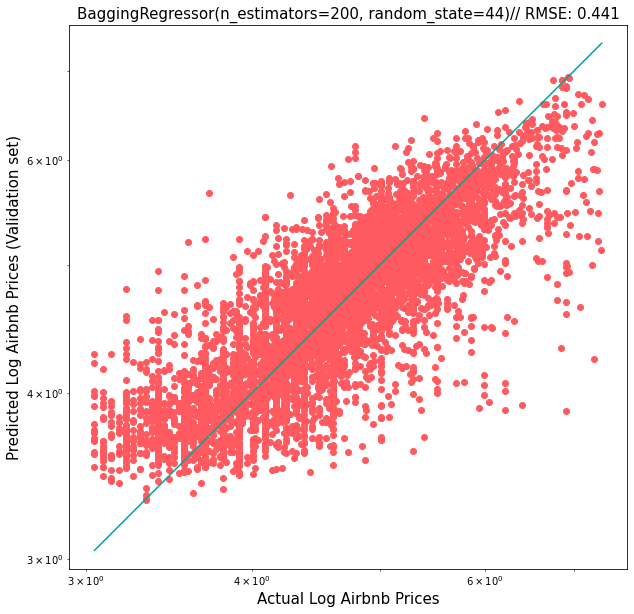

 25%|██▌       | 1/4 [02:48<08:26, 168.97s/it]

RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=44) RMSE: 0.4419658862459542
RandomForestRegressor(max_features='sqrt', n_estimators=200, random_state=44) Adjusted R^2: 0.6787732759794682
-------------------------------


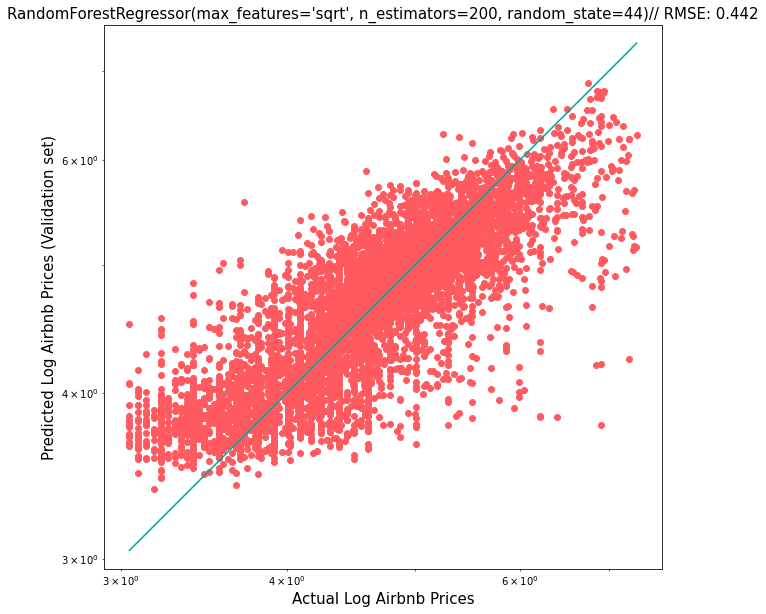

 50%|█████     | 2/4 [03:20<02:56, 88.18s/it] 

ExtraTreesRegressor(max_features='sqrt', n_estimators=200, random_state=44) RMSE: 0.44955134628665033
ExtraTreesRegressor(max_features='sqrt', n_estimators=200, random_state=44) Adjusted R^2: 0.6676522248417737
-------------------------------


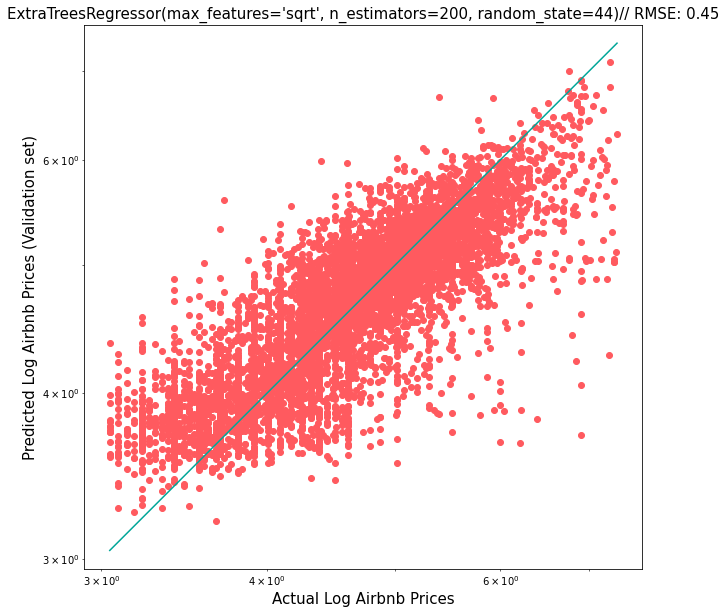

 75%|███████▌  | 3/4 [03:57<01:04, 64.76s/it]

LGBMRegressor(max_depth=12, n_estimators=200, num_leaves=100, random_state=44) RMSE: 0.4334276319028162
LGBMRegressor(max_depth=12, n_estimators=200, num_leaves=100, random_state=44) Adjusted R^2: 0.6910648240761679
-------------------------------


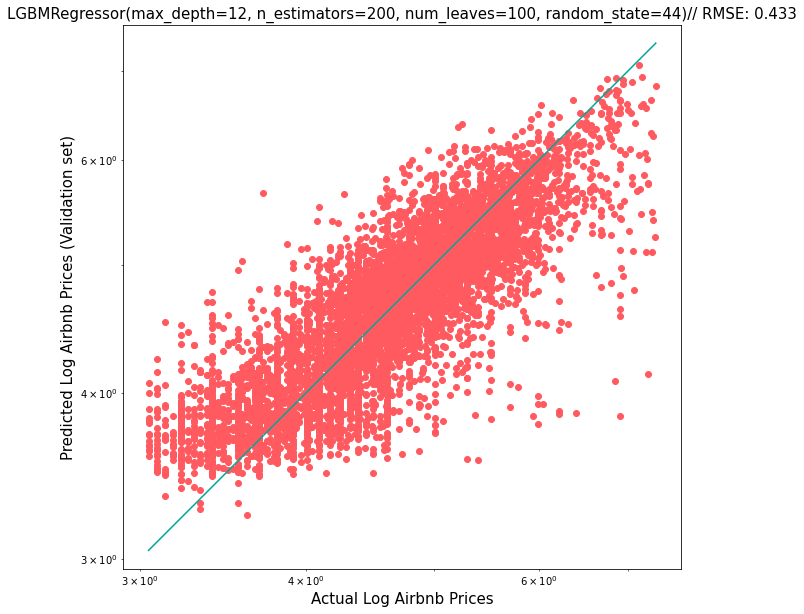

100%|██████████| 4/4 [03:59<00:00, 59.89s/it]


In [34]:
# best hyperparameters for each model
tuned_model_list =  [BaggingRegressor(n_estimators = 200, random_state = RANDOM_SEED), 
                     RandomForestRegressor(n_estimators = 200, max_features = 'sqrt', max_depth = None, random_state = RANDOM_SEED),
                     ExtraTreesRegressor(n_estimators = 200, max_features = 'sqrt', random_state = RANDOM_SEED),
                     lightgbm.LGBMRegressor(n_estimators = 200, max_depth = 12, num_leaves = 100, random_state = RANDOM_SEED)]

model_names = ['BaggingRegressor',
               'RandomForestRegressor',
               'ExtraTreesRegressor',
               'LGBMRegressor']
               
tuned_rmse_list = []
tuned_adjusted_r_square_list = []

for model in tqdm(tuned_model_list):
  
  model.fit(X_train, y_train)
  prediction = model.predict(X_val)

  # RMSE Caculation and append to list
  tuned_rmse_list.append(np.sqrt(mean_squared_error(y_val, prediction)))
  print(str(model), "RMSE:", np.sqrt(mean_squared_error(y_val, prediction)))

  # Adjusted R-square Caculation and append to list
  Adj_r2 = 1 - (1 - r2_score(y_val, prediction)) * ((len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
  tuned_adjusted_r_square_list.append(Adj_r2)
  print(str(model), "Adjusted R^2:", Adj_r2)
  print("-------------------------------")


  plt.figure(figsize=(10,10))
  plt.scatter(y_val, prediction, color = '#FF5A5F')
  plt.yscale('log')
  plt.xscale('log')

  p1 = max(max(prediction), max(y_val))
  p2 = min(min(prediction), min(y_val))
  plt.plot([p1, p2], [p1, p2], '#00A699')
  plt.xlabel('Actual Log Airbnb Prices', fontsize=15)
  plt.ylabel('Predicted Log Airbnb Prices (Validation set)', fontsize=15)
  plt.axis('equal')
  plt.title(str(model) + "// RMSE: " + str(np.round(np.sqrt(mean_squared_error(y_val, prediction)),3)), fontsize=15)
  plt.show()

**Deep learning**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               19456     
                                                                 
 dense_1 (Dense)             (None, 150)               19350     
                                                                 
 dense_2 (Dense)             (None, 150)               22650     
                                                                 
 dense_3 (Dense)             (None, 1)                 151       
                                                                 
Total params: 61,607
Trainable params: 61,607
Non-trainable params: 0
_________________________________________________________________
None


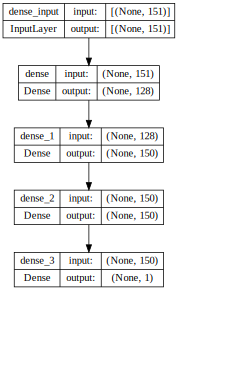

In [30]:
# Building the model
model = models.Sequential()
model.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
model.add(layers.Dense(150, activation='relu'))
model.add(layers.Dense(150, activation='relu'))
model.add(layers.Dense(1, activation='linear'))

# Compiling the model
model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mean_squared_error'])

# Printing the model summary
print(model.summary())

# Visualising the neural network
SVG(model_to_dot(model, show_layer_names=True, show_shapes=True).create(prog='dot', format='svg'))

In [31]:
%%time
# Training the deep learning model
history = model.fit(np.array(X_train), 
                    np.array(y_train),
                    validation_data=(np.array(X_val), np.array(y_val)), 
                    epochs = 50,
                    batch_size = 30,
                    verbose = False)

CPU times: user 4min 4s, sys: 9.03 s, total: 4min 14s
Wall time: 4min 1s


In [32]:
# predict
y_val_pred = model.predict(X_val)
y_train_pred = model.predict(X_train)

# Print RMSE
print("Training RMSE:", np.sqrt(round(mean_squared_error(y_train, y_train_pred),4)))
print("Validation RMSE:",  np.sqrt(round(mean_squared_error(y_val, y_val_pred),4)))

# Print Adjusted R2
Adj_r2_training = 1 - (1 - r2_score(y_train, y_train_pred)) * ((len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print("\nTraining r2:", Adj_r2_training)

Adj_r2_validation = 1 - (1 - r2_score(y_val, y_val_pred)) * ((len(y_val)-1)/(len(y_val)-X_val.shape[1]-1))
print("Validation r2:", Adj_r2_validation)

1725/1725 [==============================] - 3s 2ms/step
Training RMSE: 0.44339598554790727
Validation RMSE: 0.4689349635077342

Training r2: 0.6895826385230293
Validation r2: 0.6313346707198704


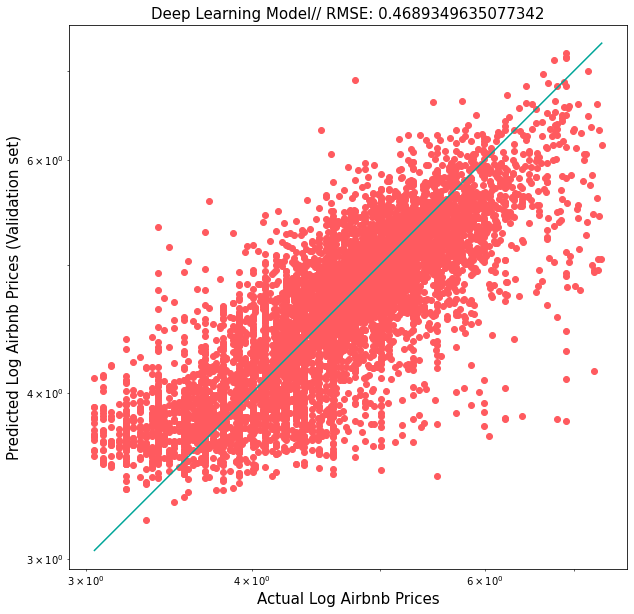

In [36]:
plt.figure(figsize=(10,10))
plt.scatter(y_val, y_val_pred, color = '#FF5A5F')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(y_val_pred), max(y_val))
p2 = min(min(y_val_pred), min(y_val))
plt.plot([p1, p2], [p1, p2], '#00A699')
plt.xlabel('Actual Log Airbnb Prices', fontsize=15)
plt.ylabel('Predicted Log Airbnb Prices (Validation set)', fontsize=15)
plt.axis('equal')
plt.title("Deep Learning Model" + "// RMSE: " + str(np.sqrt(round(mean_squared_error(y_val, y_val_pred),4))), fontsize=15)
plt.show()